## Training a neural network for Image Classification using CNN

We will be using the CIFAR-10 dataset for training the Image classifier

CIFAR-10 consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.  The 10 classes are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

More information on CIFAR-10 can be found here: http://www.cs.toronto.edu/~kriz/cifar.html  and the dataset can be found here: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

### Import Relavent libraries

In [1]:
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras import regularizers, initializers
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%matplotlib inline

print("GPU is available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Using TensorFlow backend.


GPU is available


### Load Dataset

In [2]:
# CIFAR-10 constants
# Width and height of each image.
img_size = 32
# Number of channels in each image, 3 channels: Red, Green, Blue.
img_channels = 3
nb_classes = 10
# length of the image after we flatten the image into a 1-D array
img_size_flat = img_size * img_size * img_channels
# Number of files for the training-set.
nb_files_train = 5
# Number of images for each batch-file in the training-set.
images_per_file = 10000
# Total number of images in the training-set.
nb_images_train = nb_files_train * images_per_file

In [3]:
#libraries needed for extracting data
#more info https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/cifar10.py
import os
import _pickle as pickle
from keras.utils import np_utils

def load_data(file_name):
    """
    Unpickle the given file and return the data.
    """
    
    # Directory where you want to download and save the data-set.
    file_path = os.path.join("cifar-10-batches-py", file_name)
    
    # Unpickle the given file
    print('Loading ' + file_name)
    with open(file_path, mode='rb') as file:    
        data = pickle.load(file, encoding='bytes')
    raw_images = data[b'data']
    cls = np.array(data[b'labels'])
    # Reshape the array to 4-dimensions.
    images = raw_images.reshape([-1, img_channels, img_size, img_size])    
    # move the channel dimension to the last
    images = np.rollaxis(images, 1, 4)
    
    return images, cls

def load_training_data(): 
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """
    
    # pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[nb_images_train, img_size, img_size, img_channels], 
                      dtype=int)
    cls = np.zeros(shape=[nb_images_train], dtype=int)
    
    # Begin-index for the current batch.
    begin = 0
    
    # For each data-file.
    for i in range(nb_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
        # Number of images in this batch.
        num_images = len(images_batch)
        # End-index for the current batch.
        end = begin + num_images
        # Store the images into the array.
        images[begin:end, :] = images_batch
        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch
        # The begin-index for the next batch is the current end-index.
        begin = end
        
    return images, np_utils.to_categorical(cls, nb_classes)

def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """
    images, cls = load_data(file_name="test_batch")
    
    return images, np_utils.to_categorical(cls, nb_classes)

def load_cifar():
    X_train, Y_train = load_training_data()
    X_test, Y_test = load_test_data()
    
    return X_train, Y_train, X_test, Y_test

In [4]:
X_train, Y_train, X_test, Y_test = load_cifar()

print('\nX_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

Loading data_batch_1
Loading data_batch_2
Loading data_batch_3
Loading data_batch_4
Loading data_batch_5
Loading test_batch

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [5]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

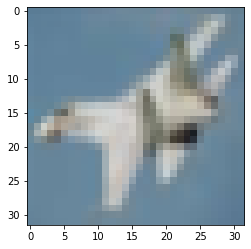

In [6]:
plt.imshow(X_test[10])


## Building CNN model architecture

#### First CNN Layer

CNN layer hyper-parameters:
`filters: 64 , kernel_size:5x5, padding: same, activation: relu, input_shape: (32, 32, 3)`

#### Second CNN Layer and max pool layer

- CNN layer hyper-parameters:
`filters: 64, kernel_size:5x5, padding: same, activation: relu`

- MaxPool layer hyper-parameters:
`pool_size: 2 , strides: 2, padding: valid`

#### Flatten layer

#### First Dense layer

Dense layer hyper-parameters:
`units/neurons: 384, activation: relu`

#### Second Dense layer

Dense layer hyper-parameters:
`units/neurons: 192, activation: relu`

#### Output layer

Dense layer hyper-parameters:
`units/neurons: 10 (number of classes),activation: softmax`


### Model Architecture

In [7]:
# kernel_initializer setup for relu
he = initializers.he_normal(seed=None)
#kernal regularizer
regularizer= regularizers.l2(l=0.001)

model = Sequential()
# Convolutional layers and Pooling
model.add(Conv2D(filters=64, kernel_size=5, kernel_initializer=he, kernel_regularizer= regularizer, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.4))

# Flattening
model.add(Flatten())
# Dense layers using regularizer l2
model.add(Dense(units=384, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(192, activation='relu'))
#output dense layer
model.add(Dense(units=10, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)              

    Param #
    channels_in * kernel_width * kernel_height * channels_out + num_channels. The addition of the number of channels is the bias terms

    So the first example: 3 * 5 * 5 * 64 + 64 = 4864, And the second: 64 * 5 * 5 * 64 + 64 = 102464
    16384 * 384 + 34 = 6291840, 382 * 192 + 192 = 73920, 192 * 10 + 10= 1930

### Compiling the model

In [8]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.0005)
model.compile(loss="categorical_crossentropy",
              optimizer='Adam', metrics=["accuracy"])

### Data Augmentation

In [9]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

### Early stopping

In [10]:
from keras.callbacks import EarlyStopping
# Set callback functions to early stop training
callbacks = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto', restore_best_weights=True)

### Training model

In [11]:
# # training method if not using data augmentation
# history = model.fit(X_train, Y_train, validation_split=.2, epochs=15,batch_size=256, verbose=2 )

#training method if using data augmentation
batch_size=256
history= model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=60,\
                    verbose=2, callbacks = [callbacks]
                             ,validation_data=(X_test,Y_test), validation_steps= len(X_test)
                            )

Epoch 1/60
 - 35s - loss: 1.5475 - accuracy: 0.4920 - val_loss: 2.4609 - val_accuracy: 0.2631
Epoch 2/60
 - 30s - loss: 1.2154 - accuracy: 0.6056 - val_loss: 1.5733 - val_accuracy: 0.4894
Epoch 3/60
 - 32s - loss: 1.0888 - accuracy: 0.6461 - val_loss: 1.0217 - val_accuracy: 0.6687
Epoch 4/60
 - 33s - loss: 1.0074 - accuracy: 0.6740 - val_loss: 0.9700 - val_accuracy: 0.6937
Epoch 5/60
 - 32s - loss: 0.9472 - accuracy: 0.6950 - val_loss: 1.1521 - val_accuracy: 0.6560
Epoch 6/60
 - 31s - loss: 0.9044 - accuracy: 0.7091 - val_loss: 0.9563 - val_accuracy: 0.7002
Epoch 7/60
 - 32s - loss: 0.8654 - accuracy: 0.7225 - val_loss: 1.0249 - val_accuracy: 0.6900
Epoch 8/60
 - 31s - loss: 0.8319 - accuracy: 0.7312 - val_loss: 0.8953 - val_accuracy: 0.7174
Epoch 9/60
 - 32s - loss: 0.8087 - accuracy: 0.7383 - val_loss: 0.8983 - val_accuracy: 0.7166
Epoch 10/60
 - 31s - loss: 0.7780 - accuracy: 0.7489 - val_loss: 0.8348 - val_accuracy: 0.7381
Epoch 11/60
 - 31s - loss: 0.7570 - accuracy: 0.7566 - val_

### Getting Filter weights

In [12]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_1 (5, 5, 3, 64)
conv2d_2 (5, 5, 64, 64)


In [13]:
# retrieve weights from the first Convolution layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filters[0][0][0]

array([0.7697273 , 0.4474221 , 0.44698727, 0.5550603 , 0.6910638 ,
       0.7334835 , 0.44259438, 0.43241295, 0.6626219 , 0.5421681 ,
       0.70588946, 0.5297239 , 0.5537701 , 0.56584513, 0.2423598 ,
       0.6526081 , 0.7039083 , 0.71914136, 0.43219185, 0.21878196,
       0.41087803, 0.44913998, 0.2854418 , 0.3390023 , 0.437975  ,
       0.5154511 , 0.573001  , 0.59553194, 0.6258392 , 0.37935302,
       0.47141013, 0.3882909 , 0.5807024 , 0.5158387 , 0.5091942 ,
       0.5673279 , 0.28547284, 0.53159416, 0.47617325, 0.29049134,
       0.54472697, 0.4999956 , 0.64088744, 0.58842313, 0.80063146,
       0.45773408, 0.53977805, 0.6611836 , 0.5879021 , 0.43091673,
       0.55852026, 0.5043491 , 0.7778543 , 0.59683454, 0.70188457,
       0.48349538, 0.48344767, 0.26028267, 0.7139461 , 0.622644  ,
       0.59902126, 0.41481963, 0.8203898 , 0.51583505], dtype=float32)

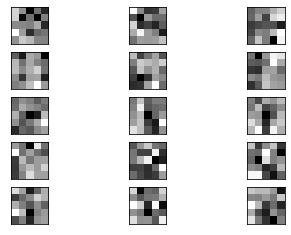

In [14]:
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j],cmap='gray')
        ix += 1
# show the figure
plt.show()

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. 

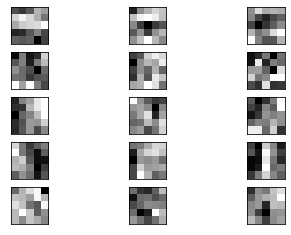

In [15]:
# retrieve weights from the second convolution layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j],cmap='gray')
        ix += 1
# show the figure
plt.show()

### Plot

In [16]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


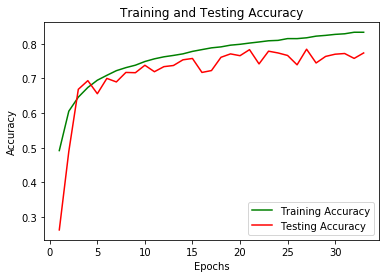

In [17]:
# for plotting the training and validation accuracy
plt.clf()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

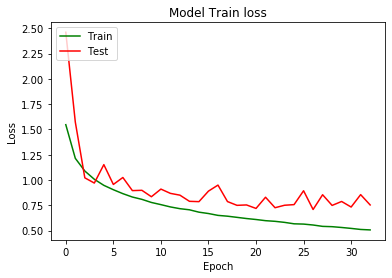

In [18]:
# summarize history for loss
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing model

In [19]:
test_loss, test_accuracy = model.evaluate(X_test,Y_test, batch_size=None)
print('Classification accuracy on the test set:: {0:.2f}%'.format(test_accuracy*100))

10000/10000 [==============================] - 3s 316us/step
Classification accuracy on the test set:: 78.44%


### Convert Images to grayscale

X_train_gray shape: (50000, 32, 32, 1)
X_test_gray shape: (10000, 32, 32, 1)


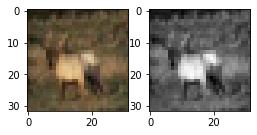

In [20]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)
print('X_train_gray shape:', X_train_gray.shape)
print('X_test_gray shape:', X_test_gray.shape)

# now we have only one channel in the images
img_channels = 1

# plotting a randomly chosen image
img = 3
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

### CNN Model Architecture

In [21]:
# kernel_initializer setup for relu
he = initializers.he_normal(seed=None)
#kernal regularizer
regularizer= regularizers.l2(l=0.001)

model = Sequential()
# Convolutional layers and Pooling
model.add(Conv2D(filters=64, kernel_size=5, kernel_initializer=he, kernel_regularizer= regularizer, padding="same", activation="relu", input_shape=[32, 32, 1]))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.4))

# Flattening
model.add(Flatten())
# Dense layers using regularizer l2
model.add(Dense(units=384, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(192, activation='relu'))
#output dense layer
model.add(Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 384)              

### Data Augmentation

In [22]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train_gray)

### Compile model

In [23]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.0005)
model.compile(loss="categorical_crossentropy",
              optimizer='Adam', metrics=["accuracy"])

### Train model

In [24]:
# # training method if not using data augmentation
# history = model.fit(X_train_gray, Y_train, epochs=50,batch_size=256, verbose=2
#                    ,validation_data=(X_test_gray,Y_test), validation_steps= len(X_test_gray))


#training method if using data augmentation
batch_size=256
history= model.fit_generator(datagen.flow(X_train_gray, Y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=60,\
                    verbose=2, callbacks = [callbacks]
                             ,validation_data=(X_test_gray,Y_test), validation_steps= len(X_test_gray)
                            )

Epoch 1/60
 - 31s - loss: 1.7191 - accuracy: 0.4306 - val_loss: 2.4274 - val_accuracy: 0.2699
Epoch 2/60
 - 30s - loss: 1.3399 - accuracy: 0.5609 - val_loss: 1.5117 - val_accuracy: 0.4991
Epoch 3/60
 - 30s - loss: 1.1966 - accuracy: 0.6112 - val_loss: 1.1068 - val_accuracy: 0.6488
Epoch 4/60
 - 30s - loss: 1.1158 - accuracy: 0.6381 - val_loss: 1.3145 - val_accuracy: 0.5964
Epoch 5/60
 - 30s - loss: 1.0654 - accuracy: 0.6570 - val_loss: 1.1321 - val_accuracy: 0.6445
Epoch 6/60
 - 30s - loss: 1.0064 - accuracy: 0.6739 - val_loss: 1.2639 - val_accuracy: 0.6132
Epoch 7/60
 - 31s - loss: 0.9823 - accuracy: 0.6817 - val_loss: 1.1395 - val_accuracy: 0.6516
Epoch 8/60
 - 30s - loss: 0.9477 - accuracy: 0.6942 - val_loss: 0.9992 - val_accuracy: 0.6894
Epoch 9/60
 - 30s - loss: 0.9263 - accuracy: 0.6986 - val_loss: 0.9378 - val_accuracy: 0.7063
Epoch 10/60
 - 30s - loss: 0.8920 - accuracy: 0.7105 - val_loss: 0.9798 - val_accuracy: 0.6947
Epoch 11/60
 - 30s - loss: 0.8723 - accuracy: 0.7180 - val_

### Get filter weights

In [25]:
# retrieve weights from the first Convolution layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filters[0][0][0]

array([0.6412154 , 0.51500636, 0.5911801 , 0.3547009 , 0.53174466,
       0.5674237 , 0.5692752 , 0.61176544, 0.47280282, 0.5133312 ,
       0.51642615, 0.5428278 , 0.5673159 , 0.60020745, 0.40974215,
       0.6291777 , 0.5209447 , 0.41575468, 0.3517961 , 0.60250175,
       0.592659  , 0.5199535 , 0.4548078 , 0.78492635, 0.61633193,
       0.44379857, 0.5935533 , 0.55654246, 0.5097937 , 0.7492558 ,
       0.42144305, 0.474224  , 0.461529  , 0.733363  , 0.4561056 ,
       0.7259484 , 0.6815212 , 0.4909032 , 0.44641343, 0.52137554,
       0.63985294, 0.44013283, 0.6232764 , 0.56062317, 0.5121252 ,
       0.5062979 , 0.5901291 , 0.45625508, 0.3541209 , 0.37156725,
       0.65100986, 0.5247029 , 0.34480926, 0.66122913, 0.49761355,
       0.46740267, 0.36544907, 0.55707943, 0.4879926 , 0.75503445,
       0.26602483, 0.41826507, 0.5212367 , 0.42321062], dtype=float32)

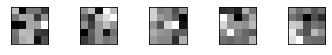

In [26]:
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 5, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j],cmap='gray')
        ix += 1
# show the figure
plt.show()

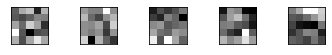

In [27]:
# retrieve weights from the second convolution layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 5, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

### Plot

In [28]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


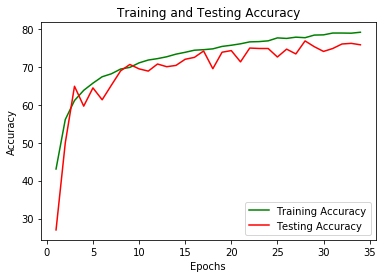

In [29]:
# for plotting the training and validation accuracy
plt.clf()
Accuracy=[]
Val_acc=[]
accuracy = history.history['accuracy']
Accuracy[:] = [x * 100 for x in accuracy]
Accuracy = list(np.around(np.array(Accuracy),2))
val_accuracy = history.history['val_accuracy']
Val_acc[:] = [x * 100 for x in val_accuracy]
Val_acc = list(np.around(np.array(Val_acc),2))
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, Accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, Val_acc, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

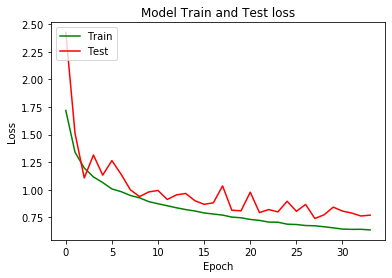

In [30]:
# summarize history for loss
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model Train and Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing the grayscale model

In [31]:
test_loss, test_accuracy = model.evaluate(X_test_gray,Y_test, batch_size=None)
print('Classification accuracy on the test set:: {0:.2f}%'.format(test_accuracy*100.))

10000/10000 [==============================] - 3s 276us/step
Classification accuracy on the test set:: 76.84%
